# Visual Feature for Image Retrieval

The link to pre-computed features, codebooks, and results: https://drive.google.com/drive/folders/1Br8Z4iV-OpLb8Nen-0WKPP9L55E-eiZR?usp=sharing
Simply unzip these files and put it in the same folder as this file.

If one wants to generate the features and evalute the result on its own, make sure to create `features/`, `codebook/`, `results/ranking/`, and `results/dist/` folders.

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import glob
import pickle
from IPython.display import HTML, display

from feature_extraction.color_histogram import color_histogram
from feature_extraction.grid_color_moment import grid_color_moment
from feature_extraction.gabor_texture import gabor_texture, genGaborFilters
from feature_extraction.local_descriptors import localDescriptor, VLAD, genCodeBook

In [2]:
# parameters
NUM_OF_CATEGORY = 35
NUM_OF_RELEVANT = 20

# categories
categories = [c.split('/')[1] for c in glob.glob('data/*')]
categories.sort()

def getCategory(index):
    return categories[index // NUM_OF_RELEVANT]

def getFilename(index):
    category = getCategory(index)
    return category, os.path.join('data', category, category + '_' + str(index % NUM_OF_RELEVANT + 1) + '.jpg')

## Feature Extraction
### Color Similarity

- <strong>Grid color moments</strong>: 

    Slice image into grids and compute 1st, 2nd, and 3rd moments for each grid in each color channel. 
    Note that each component (moment) has not been normalized. 

    Here are the parameters that have been tested:
    <ul>
        <li><em>cs</em>: color space. RGB, HSV, and YCbCr are tested.</li>
        <li><em>grids</em>: the number of grids along height and width.
        1x1 (i.e. global), 2x2, 3x3, ..., 10x10 are tested.</li>
    </ul>

    The implementation is in `feature_extraction/grid_color_moment.py`.
    
    
- <strong>Color Histogram</strong>:

    Slice image into grids and compute the color histogram for each grid. 
    Since the image size is not consistant over the dataset, the histogram of each grid is dividing by the number of pixels in that grid.
    
    Here are the parameters that have been tested:
    <ul>
        <li><em>cs</em>: color space. RGB and HSV are tested.</li>
        <li><em>n_bin</em>: the number of bins. For RGB, (4x4x4) are tested, and (18x3x3) for HSV.</li>
        <li><em>grids</em>: the number of grids along height and width. 
            1x1 (i.e. global), 2x2, 3x3, ..., 10x10 are tested.</li>
    </ul>
    
    The implementation is in `feature_extraction/color_histogram.py`.

### Texture/Shape Similarity
- <strong>Gabor texture</strong>:
    
    The Gabor kernel is generated from the OpenCV library. However, the parameters for generating Gabor wavelet ($\sigma$, $\gamma$, and $\lambda$) is compute by myself according to [2]:
    <ul>
        <li>$\sigma = \sigma_x$</li>
        <li>$\gamma = \frac{\sigma_x}{\sigma_y} = \frac{\sigma_\nu}{\sigma_\mu}$</li>
        <li>$\lambda = \frac{1}{U_h}$ (not sure if this is right)</li>
    </ul>
    
    For the aspect ratio $\gamma$, I found the result calculated from the formula (for computing $\sigma_\nu$) in the original paper [1] is weird (hope it is not because I implemented it wrong.) Therefore, I derived it by myself and the result (half-peak spectrum) seems right. ($\sigma_\nu = \tan(\frac{\pi}{2K})\sqrt{\frac{U_h^2}{2\ln{2}}-\sigma_\mu^2}$)
    <br> For the visualization of the Gabor filters, please see the appendix.
    
    After the image convoluted with the Gabor filters, the mean and standard deviation of the results are computed for each grid.
    
    Here are the parameters that have been tested:
    <ul>
        <li><em>cs</em>: color space. GRAY, RGB and HSV are tested.</li>
        <li><em>K, S</em>: orientation and scale factor of the Gabor wavelet. 
            (8, 6), (6, 8), and (12, 8) are tested.</li>
        <li><em>U_h, U_l</em>: bandwidth factor of the Gabor wavelet. 
            (0.4, 0.05) are tested.</li>
        <li><em>grids</em>: the number of grids along height and width. 
            1x1 (i.e. global), 2x2, 3x3, ..., 10x10 are tested.</li>
    </ul>
    
    The implementation is in `feature_extraction/gabor_texture.py`.
    

### Local Feature Similarity
- <strong>Local Feature Matching</strong>:
    
    SIFT and ORB [3] detectors and descriptors implementated by OpenCV are used. 
    Brute-force matching are used to matching the both features between images, while I used L2 distance for SIFT and Hamming distance with cross check for ORB as in [4].
    The similarity between images is the number of matched descriptors. Images that are similar should have more matches than those who are not.
    
    I also tried slicing images into grids and counted how many matches between the corresponding grids of the images as the similarity of them.
    
    Here are the parameters that have been tested:
    <ul>
        <li><em>cs</em>: color space. RGB and GRAY are tested.</li>
        <li><em>grids</em>: the number of grids along height and width.
        1x1 (i.e. global), 2x2, 4x4, 8x8 are tested.</li>
    </ul>
    
    The implementation is in `feature_extraction/local_decsriptors.py`.


- <strong>Histogram of Visual Words</strong>:
    
    Several codebooks are trained using K-means implementated by scikit-learn over a image retrievel dataset Caltech 101 [6] with different Ks (i.e. number of centroids.) Both SIFT and ORB are tested. Only RGB color space are tested.
    
    The numbers of each visual words are compute to form a histogram for each grid, and it is normalized by dividing by the total number of visual words in that grid.
    
    Here are the parameters that have been tested:
    <ul>
        <li><em>k</em>: number of centroids (i.e. visual words). 16, 32, 64, and 128 are tested.</li>
        <li><em>det</em>: feature detector. SIFT and ORB are tested.</li>
        <li><em>grids</em>: the number of grids along height and width.
        1x1 (i.e. global), 2x2, 4x4, 8x8 are tested.</li>
    </ul>
    
    The implementation is in `feature_extraction/local_decsriptors.py`.
    
    
- <strong>VLAD</strong>:

    VLAD are implemented according to [5], while the PCA and ADT are not implemented. The same codebooks for computing visual word are used for VLAD as well. 

    Here are the parameters that have been tested:
    <ul>
        <li><em>k</em>: number of centroids (i.e. visual words). 16, 32, 64, and 128 are tested.</li>
        <li><em>det</em>: feature detector. SIFT and ORB are tested.</li>
        <li><em>grids</em>: the number of grids along height and width.
        1x1 (i.e. global), 2x2, 4x4, 8x8 are tested.</li>
    </ul>
    
    The implementation is in `feature_extraction/local_decsriptors.py`.

### Fusion
- <strong>Combined Features</strong>:
    
    All the features above (except SIFT & ORB feature matching) with its best configuration are combined to be a new feature. Each type of feature are normalized by dividing by the standard deviation of that type feature, and then all the features are concatenated into a new feature.
    
    
### Reference:
- [1] Texture features for browsing and retrieval of image data, https://ieeexplore.ieee.org/document/531803
- [2] Gabor濾波器詳解, https://www.itread01.com/content/1546890854.html
- [3] OpenCV ORB (Oriented FAST and Rotated BRIEF), https://docs.opencv.org/4.4.0/d1/d89/tutorial_py_orb.html
- [4] OpenCV Feature Matching, https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
- [5] Python implementation of VLAD for a CBIR system, https://github.com/jorjasso/VLAD
- [6] Caltech 101 dataset, http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [3]:
# Feature extraction
def extract_feature(name, method, cs='RGB', path='features/', overwrite=False, **kwargs):
    
    # load from files
    filepath = os.path.join(path, name + '.npy')
    if not overwrite and os.path.isfile(filepath):
        print('load pre-generated features from file')
        return np.load(filepath, allow_pickle=True)
    
    features = []
    for category in categories:
        for i in range(1, 21):

            # read image
            filename = os.path.join('data', category, category + '_' + str(i) + '.jpg')
            
            # color space
            img = cv2.imread(filename)
            if cs == 'RGB':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif cs == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cs == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            elif cs == 'GRAY':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # extract feature
            feature = method(img, **kwargs)

            # store feature
            features.append(feature)
            
    # save features into file
    features = np.array(features)
    np.save(filepath, features)
    
    return features
    

In [4]:
# Grid Color Moment
def genGCM(cs, grids, ow=False):
    # filename
    name = 'gcm_g{}_{}'.format(grids, cs)

    # extract features
    feature = extract_feature(name, grid_color_moment, overwrite=ow, cs=cs, gx=grids, gy=grids)
    # shape: (grids)^2 * color_channel * 3(mean & std & skewness)
    
    return name, feature

# Color Histogram
def genCH(cs, grids, n_bin, ow=False):
    # filename
    name = 'ch_g{}_{}_({})'.format(grids, cs, '_'.join(str(x) for x in n_bin))

    # extract features
    feature = extract_feature(name, color_histogram, overwrite=ow, cs=cs, gx=grids, gy=grids, n_bin=n_bin)
    # shape: (grids)^2 * n_bin
    return name, feature


# Gabor Texture
def genGabor(cs, grids, K, S, ow=False):
    name = 'gabor_g{}_k{}_s{}_{}'.format(grids, K, S, cs)

    # extract features
    gabor_filters = genGaborFilters(K=K, S=S)
    feature = extract_feature(name, gabor_texture, overwrite=ow, cs=cs, filters=gabor_filters, gx=grids, gy=grids)
    # shape: K * S * (grids)^2 * 2(mean & std)
    return name, feature

# Local Descriptors in various numbers of grids
def genLD(cs, grids, det='SIFT', ow=False):
    '''
        grids: needs to be power of 2
    '''
    name = '{}_g{}_{}'.format(det, grids, cs)
    
    # detector
    if det == 'ORB':
        detector = cv2.ORB_create()
    else:
        detector = cv2.SIFT_create()

    # compute SIFT descriptor
    feature = extract_feature(name, localDescriptor, overwrite=ow, cs=cs, detector=detector, g=grids)
    
    # shape: (grids)^2 * n descriptor * d component
    return name, feature

# VLAD
def genVLAD(k, des, des_name, codebook, grids, ow=False):
    # parameters
    name = 'k{}_{}'.format(k, des_name)

    # compute VLAD descriptor
    feature_vlad, feature_hist = VLAD(name, des, k, codebook, grids, overwrite=ow)
    # (grids)^2 * k class * d components 
    return 'vlad_'+name, feature_vlad, 'hist_'+name, feature_hist

## Evaluations

Besides different parameter configurations, I also test different distance function. 
L1 and L2 distance are tested for grid color moments, color histogram, gabor texture, histogram of visual word, and VLAD. 

For the local descriptors matching, L2 distance is used for SIFT and Hamming distance with cross check for ORB. 2 nearest neighbors are found using KNN to perform ratio test for SIFT (with ratio=0.7).

In [5]:
# Ranking
def ranking(name, features, dist_func, ascend=True, symmetric=True, path='results/', overwrite=False, **kargs):
    '''
        ascend: ranking in ascending (for distance) or descending order (for similarity)
        symmetric: if the distance function has commutative property, the process can be speedup
    '''
    # load from files
    rank_filepath = os.path.join(path, 'ranking', name + '.npy')
    dist_filepath = os.path.join(path, 'dist', name + '.npy')
    if not overwrite and os.path.isfile(rank_filepath) and os.path.isfile(dist_filepath):
        print('load pre-computed results from file')
        return np.load(rank_filepath, allow_pickle=True), np.load(dist_filepath, allow_pickle=True)
    
    # distance/similarity
    n_feature = len(features)
    dist = []
    if symmetric:
        for i in range(n_feature):
            dist_row = []
            # reduce reduntant computation
            for j in range(i):
                dist_row.append(dist[j][i])
            # computer features
            for j in range(i, n_feature):
                dist_row.append(dist_func(features[i], features[j], **kargs))
            
            dist.append(dist_row)
    else:
        for i in range(n_feature):
            dist_row = []
            # computer features
            for j in range(n_feature):
                dist_row.append(dist_func(features[i], features[j], **kargs))
            
            dist.append(dist_row)
    
    # ranking (including the target image itself)
    ranked_all = np.argsort(dist, axis=1)
    if not ascend:
        # reverse for descending order
        ranked_all = ranked_all[:, ::-1]
    
    # baseline check: the first retrived image should be the target image itself
    ranked = []
    for i in range(len(ranked_all)):
        target_rank = 0
        if ranked_all[i, 0] != i:
            target_rank = np.where(ranked_all[i] == i)
            print('Baseline check Failed: ', i, ranked_all[i, 0], target_rank)
            
        # remove the target image from the result
        ranked.append(np.delete(ranked_all[i], target_rank))
        
    # save features into file
    ranked = np.array(ranked)
    dist = np.array(dist)
    np.save(rank_filepath, ranked)
    np.save(dist_filepath, dist)
    
    return np.array(ranked), dist

# distance/similarity function
def Ln_distance(a, b, ord=1, weight=None):
    if weight is not None:
        # weighting over each feature
        return np.linalg.norm((a-b)*weight, ord=ord)
    else:
        return np.linalg.norm(a-b, ord=ord)

# local feature matching function
def matching(query_des, train_des, match_func, grids=1, rt=None):
    '''
        k: find best k match of each query descriptor
    '''
    if grids == 1:
        query_des = [query_des]
        train_des = [train_des]
    
    # run over each grid
    counts = 0
    for des_q, des_t in zip(query_des, train_des):
        # skip empty grids
        if len(des_q) == 0 or len(des_t) == 0:
            continue
        
        # matching
        if rt is None:
            matches = match_func(np.array(des_q), np.array(des_t))
            counts += len(matches)
        else:
            # knn & ratio test
            matches = match_func(np.array(des_q), np.array(des_t), k=2)
            
            good_match = 0
            for m in matches:
                if len(m) > 1 and m[0].distance < rt * m[1].distance:
                    # if the distance of best match is much smaller than the second
                    # then it is a good match
                    good_match += 1
                    
            counts += good_match
    
    return counts
    

In [6]:
def computeMAP(ranking):
    # precisiion & recall
    P = []
    R = []
    
    # AP of each image
    APs = []
    
    for i in range(len(ranking)):
        
        tp = 0 # true positive
        fp = 0 # false positive 

        precision = []
        recall = []
        AP = []
        
        cur_category = i // NUM_OF_RELEVANT
        
        for j in range(len(ranking[i])):
            if ranking[i, j] // NUM_OF_RELEVANT == cur_category:
                # matched
                tp += 1
                precision.append(tp / (tp + fp))
                recall.append(tp / NUM_OF_RELEVANT)
                # add precision in to the list
                AP.append(precision[-1])
            else:
                # mismatched
                fp += 1
                precision.append(tp / (tp + fp))
                recall.append(tp / NUM_OF_RELEVANT)
                
        AP = np.mean(AP)
        APs.append(AP)
        P.append(precision)
        R.append(recall)
        
    MMAP = np.mean(APs)
    MAP = [np.mean(APs[i*NUM_OF_RELEVANT:(i+1)*NUM_OF_RELEVANT]) for i in range(NUM_OF_CATEGORY)]
    P = np.mean(P, axis=0)
    R = np.mean(R, axis=0)
    
    return MMAP, MAP, P, R     

In [7]:
# Ln distance
def evalLn(fname, feature, ord, weight=None, ow=False):
    # filename
    name = fname + '_L{}'.format(ord)
    
    # ranking
    ranked, _ = ranking(name, feature, Ln_distance, overwrite=ow, ord=ord, weight=weight)
    # MAP
    MMAP, MAP, P, R = computeMAP(ranked)
    
    return name, {'MMAP': MMAP, 'MAP': MAP, 'P': P, 'R': R}


In [8]:
# Evaluations
results = {}

In [9]:
# Grid Color Moment
for cs in ['RGB', 'HSV', 'YCrCb']:
    for grids in range(1, 10):
        # generate (or load) features
        name_gcm, feature_gcm = genGCM(cs, grids)
        print(name_gcm, feature_gcm.shape)
        
        # evaluation (or load result)
        for order in [1, 2]:
            name, result = evalLn(name_gcm, feature_gcm, ord=order)
            results[name] = result

load pre-generated features from file
gcm_g1_RGB (700, 9)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g2_RGB (700, 36)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g3_RGB (700, 81)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g4_RGB (700, 144)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g5_RGB (700, 225)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g6_RGB (700, 324)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g7_RGB (700, 441)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g8_RGB (700, 576)
load pre-computed re

In [10]:
# Color Histogram
for cs, n_bin in zip(['RGB', 'HSV'], [[4, 4, 4], [18, 3, 3]]):
    for grids in range(1, 10):
        # generate (or load) features
        name_ch, feature_ch = genCH(cs, grids, n_bin)
        print(name_ch, feature_ch.shape)
        
        # evaluation (or load result)
        for order in [1, 2]:
            name, result = evalLn(name_ch, feature_ch, ord=order)
            results[name] = result
        

load pre-generated features from file
ch_g1_RGB_(4_4_4) (700, 64)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g2_RGB_(4_4_4) (700, 256)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g3_RGB_(4_4_4) (700, 576)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g4_RGB_(4_4_4) (700, 1024)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g5_RGB_(4_4_4) (700, 1600)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g6_RGB_(4_4_4) (700, 2304)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g7_RGB_(4_4_4) (700, 3136)
load pre-computed results from file
load pre-computed results from file
load pre-generated featu

In [11]:
# Gabor Texture
for cs in ['GRAY', 'RGB', 'HSV']:
    for K, S in [[6, 8], [8, 6], [12, 8]]:
        for grids in range(1, 10):
            # generate (or load) features
            name_gabor, feature_gabor = genGabor(cs, grids, K, S)
            print(name_gabor, feature_gabor.shape)

            # evaluation (or load result)
            for order in [1, 2]:
                weight = 1/np.std(feature_gabor, axis=0)
                name, result = evalLn(name_gabor, feature_gabor, ord=order, weight=weight)
                results[name] = result

load pre-generated features from file
gabor_g1_k6_s8_GRAY (700, 96)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g2_k6_s8_GRAY (700, 384)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g3_k6_s8_GRAY (700, 864)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g4_k6_s8_GRAY (700, 1536)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g5_k6_s8_GRAY (700, 2400)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g6_k6_s8_GRAY (700, 3456)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g7_k6_s8_GRAY (700, 4704)
load pre-computed results from file
load pre-computed results from file
load pre-g

load pre-generated features from file
gabor_g5_k6_s8_HSV (700, 2400)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g6_k6_s8_HSV (700, 3456)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g7_k6_s8_HSV (700, 4704)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g8_k6_s8_HSV (700, 6144)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g9_k6_s8_HSV (700, 7776)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g1_k8_s6_HSV (700, 96)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gabor_g2_k8_s6_HSV (700, 384)
load pre-computed results from file
load pre-computed results from file
load pre-generat

In [12]:
# Local Descriptor Matching -- SIFT
det = 'SIFT'
matcher = cv2.BFMatcher()
for cs in ['RGB', 'GRAY']:
    for grids in [1, 2, 4, 8]:
        # generate (or load) features
        name_ld, feature_ld = genLD(cs, grids, det)
        print(name_ld, feature_ld.shape)

        # evaluation (or load result)
        ranked, _ = ranking(name_ld, feature_ld, matching, ascend=False, symmetric=False, overwrite=False, match_func=matcher.knnMatch, grids=grids, rt=0.7)
        # MAP
        MMAP, MAP, P, R = computeMAP(ranked)

        results[name_ld] = {'MMAP': MMAP, 'MAP': MAP, 'P': P, 'R': R}
            

load pre-generated features from file
SIFT_g1_RGB (700,)
load pre-computed results from file
load pre-generated features from file
SIFT_g2_RGB (700, 4)
load pre-computed results from file
load pre-generated features from file
SIFT_g4_RGB (700, 16)
load pre-computed results from file
load pre-generated features from file
SIFT_g8_RGB (700, 64)
load pre-computed results from file
load pre-generated features from file
SIFT_g1_GRAY (700,)
load pre-computed results from file
load pre-generated features from file
SIFT_g2_GRAY (700, 4)
load pre-computed results from file
load pre-generated features from file
SIFT_g4_GRAY (700, 16)
load pre-computed results from file
load pre-generated features from file
SIFT_g8_GRAY (700, 64)
load pre-computed results from file


In [13]:
# Local Descriptor Matching -- ORB
det = 'ORB'
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for cs in ['RGB', 'GRAY']:
    for grids in [1, 2, 4, 8]:
        # generate (or load) features
        name_ld, feature_ld = genLD(cs, grids, det)
        print(name_ld, feature_ld.shape)

        # evaluation (or load result)
        ranked, _ = ranking(name_ld, feature_ld, matching, ascend=False, symmetric=False, overwrite=False, match_func=matcher.match, grids=grids)
        # MAP
        MMAP, MAP, P, R = computeMAP(ranked)

        results[name_ld] = {'MMAP': MMAP, 'MAP': MAP, 'P': P, 'R': R}
            

load pre-generated features from file
ORB_g1_RGB (700,)
load pre-computed results from file
load pre-generated features from file
ORB_g2_RGB (700, 4)
load pre-computed results from file
load pre-generated features from file
ORB_g4_RGB (700, 16)
load pre-computed results from file
load pre-generated features from file
ORB_g8_RGB (700, 64)
load pre-computed results from file
load pre-generated features from file
ORB_g1_GRAY (700,)
load pre-computed results from file
load pre-generated features from file
ORB_g2_GRAY (700, 4)
load pre-computed results from file
load pre-generated features from file
ORB_g4_GRAY (700, 16)
load pre-computed results from file
load pre-generated features from file
ORB_g8_GRAY (700, 64)
load pre-computed results from file


In [14]:
# VLAD & Histogram of Visual Word
db_folder = '101_ObjectCategories'
for detector in ['SIFT', 'ORB']:
    for k in [16, 32, 64, 128]:
        # generate (or load) codebook
        codebook = genCodeBook(db_folder, k, detector)

        for grids in [1, 2, 4, 8]:
            # generate (or load) local descriptor
            name_ld, feature_ld = genLD(cs='RGB', grids=grids, det=detector)

            # generate (or load) features
            name_vlad, feature_vlad, name_hist, feature_hist = genVLAD(k, feature_ld, name_ld, codebook, grids)
            print(name_vlad, feature_vlad.shape)
            print(name_hist, feature_hist.shape)

            # evaluation (or load result)
            for order in [1, 2]:
                # vlad
                name, result = evalLn(name_vlad, feature_vlad, ord=order)
                results[name] = result
                # hist
                name, result = evalLn(name_hist, feature_hist, ord=order)
                results[name] = result

load code book from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g1_RGB (700, 2048)
hist_k16_SIFT_g1_RGB (700, 16)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g2_RGB (700, 8192)
hist_k16_SIFT_g2_RGB (700, 64)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g4_RGB (700, 32768)
hist_k16_SIFT_g4_RGB (700, 256)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g8_RGB (700, 131072)
hist_k16_SIFT_

load pre-computed features from file
vlad_k128_ORB_g1_RGB (700, 4096)
hist_k128_ORB_g1_RGB (700, 128)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k128_ORB_g2_RGB (700, 16384)
hist_k128_ORB_g2_RGB (700, 512)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k128_ORB_g4_RGB (700, 65536)
hist_k128_ORB_g4_RGB (700, 2048)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k128_ORB_g8_RGB (700, 262144)
hist_k128_ORB_g8_RGB (700, 8192)
load pre-computed results from file
load

In [15]:
# Fusion
# combine features of each method (except SIFT & ORB feature matching) with its best configuration
best_methods = [
    'gcm_g7_HSV_L1', 
    'ch_g3_HSV_(18_3_3)_L1', 
    'gabor_g7_k6_s8_GRAY_L1',
#     'SIFT_g1_RGB', 
#     'ORB_g1_GRAY',
    'hist_k128_SIFT_g1_RGB_L1',
    'vlad_k16_SIFT_g1_RGB_L2',
]

# Grid Color Moment (gcm_g7_HSV_L1)
name_gcm, feature_gcm = genGCM(cs='HSV', grids=7)
print(name_gcm, feature_gcm.shape)

# Color Histogram (ch_g3_HSV_(18_3_3)_L1)
name_ch, feature_ch = genCH(cs='HSV', grids=3, n_bin=(18, 3, 3))
print(name_ch, feature_ch.shape)

# Gabor Texture (gabor_g7_k6_s8_GRAY_L1)
name_gabor, feature_gabor = genGabor(cs='GRAY', grids=7, K=6, S=8)
print(name_gabor, feature_gabor.shape)

# Histogram of Visual Word (hist_k128_SIFT_g1_RGB_L1)
codebook = genCodeBook('101_ObjectCategories', 128, 'SIFT')
name_ld, feature_ld = genLD(cs='RGB', grids=1, det='SIFT')
_, _, name_hist, feature_hist = genVLAD(128, feature_ld, name_ld, codebook, grids=1)
print(name_hist, feature_hist.shape)

# VLAD (vlad_k16_SIFT_g1_RGB_L2)
codebook = genCodeBook('101_ObjectCategories', 16, 'SIFT')
name_ld, feature_ld = genLD(cs='RGB', grids=1, det='SIFT')
name_vlad, feature_vlad, _, _ = genVLAD(16, feature_ld, name_ld, codebook, grids=1)
print(name_vlad, feature_vlad.shape)

# Combine all features
feature_fusion = [feature_gcm, feature_ch, feature_gabor, feature_hist, feature_vlad]
# normalize each feature (standard normalization)
for i in range(len(feature_fusion)):
    feature_fusion[i] = feature_fusion[i] / np.std(feature_fusion[i])
# concatenate all features
name_fusion = 'fusion'
feature_fusion = np.concatenate(feature_fusion, axis=1)
print(name_fusion, feature_fusion.shape)
# save to file
np.save('features/' + name_fusion, feature_fusion)

# evaluation (or load result)
for order in [1, 2]:
    name, result = evalLn(name_fusion, feature_fusion, ord=order)
    results[name] = result

load pre-generated features from file
gcm_g7_HSV (700, 441)
load pre-generated features from file
ch_g3_HSV_(18_3_3) (700, 1458)
load pre-generated features from file
gabor_g7_k6_s8_GRAY (700, 4704)
load code book from file
load pre-generated features from file
load pre-computed features from file
hist_k128_SIFT_g1_RGB (700, 128)
load code book from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g1_RGB (700, 2048)
fusion (700, 8779)
load pre-computed results from file
load pre-computed results from file


# Results

Here the result of each method are visualized here. 
Each table shows the MAP across the dataset and MAPs of the best and worst 2 catrgories of each result and sorted by the MAP across the dataset. The PR curve for each result are also visualized under each table.
To compare between methods, the MAP of each category are visualized in a bar chart for each method to give a better view for understanding in which categories the method performs well.

## Comparison between Methods -- Features
When comparing between methods, surprisingly, fusion outperforms all other methods, which is probably because it combines all kinds of features and takes the advantages out of them.

For color similarity methods, they perform better in the categories which the color is consistant over images such as <em>sprite</em> and <em>blue_pillow</em>. For <em>goggles</em>, even though the goggles has various colors, since the background color of all the images is the same (white), grid color moments perform good on it. For those with various object and background color such as <em>nba_jersey</em> and <em>sweeping_robot</em>, color similarity methods performs poorly on them. 

For Gabor texture, it works better categories that the pattern is unique and consistant such as <em>garment</em>, which the number 16 is easy to identify. For <em>goggles</em>, since the texture information is extract in grayscale color space, the color did not influence it ability to classify the object with similar shape.

For the local feature similarity methods, they perform well in certain categories which the object has more unique detail and almost the same between images (unlike <em>bicycle</em> and <em>sweeping_robot</em>), such as <em>gge_snack</em> and <em>korean_snack</em>.


## Comparison within Methods -- Parameters

### Color Space
In terms of color space, color similarity methods generally performs the best with HSV color space.
However, for Gabor texture, the grayscale is better than HSV and RGB.
For local descriptor matching, there is no absolute best choice between RGB and grayscale.

### Region -- Grids
For color similarity methods, too few grids (1x1 and 2x2) will results in poor results. Giving more spatial informtaion (such as slicing more grids) could increase the performance.
For Gabor texture, more grids could give better performance. This may be because as the grids become smaller, the texture of each grids becomes more uniform and thus the response of each Gabor filter in each grid stands out.
For the local feature similarity methods, less grids performs better. This is because the object to be classified is not always in the same position and rotation in the image, the spatial distribution of the local feature is different between images. And since I only match or compare the distance between the correspond grids rather than cross grids, the matches and histogram becomes less similar as the number of grids increases.

### Local Descriptor
Generally, SIFT performs better than ORB.

### Distance Function
Generally, L1 performs better then L2 distance.

In [16]:
# Comparison between methods
def compareResult(results, order=None, prefix=None):
    
    table = """
    <table>
    <tr>
    <th>categories vs. methods</th>
    <th>MAP</th>
    <th>Best Two Categories (w/ MAP)</th>
    <th>Worst Two Categories (w/ MAP)</th>
    </tr>
    """
    
    # filter key
    if prefix is not None:
        results = {key: val for key, val in results.items() if key.startswith(prefix)}
    
    # sort key
    if order is None:
        # default: sort by method name
        sorted_key = sorted(results)
    else:
        # sort by value
        sorted_key = sorted(results, key=lambda x:results[x][order], reverse=True)
        
    # figure size
    org_fz = plt.rcParams['figure.figsize']
    org_dpi = plt.rcParams['figure.dpi']
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 100
        
    for key in sorted_key:
        MAP = results[key]['MAP']
        MAP_sort = np.argsort(MAP)
        # print(MAP_sort)

        table += """
        <tr>
        <td>{}</td>
        <td>{:.3f}</td>
        <td>{} ({:.3f}), {} ({:.3f})</td>
        <td>{} ({:.3f}), {} ({:.3f})</td>
        </tr>
        """.format(key, results[key]['MMAP'], categories[MAP_sort[-1]], MAP[MAP_sort[-1]], categories[MAP_sort[-2]], MAP[MAP_sort[-2]], categories[MAP_sort[0]], MAP[MAP_sort[0]], categories[MAP_sort[1]], MAP[MAP_sort[1]])

        # PR curve
        plt.plot(results[key]['R'], results[key]['P'], label=key)


    table += "</table>"
    display(HTML(table))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.show()
    
    # reset figure size
    plt.rcParams['figure.figsize'] = org_fz
    plt.rcParams['figure.dpi'] = org_dpi

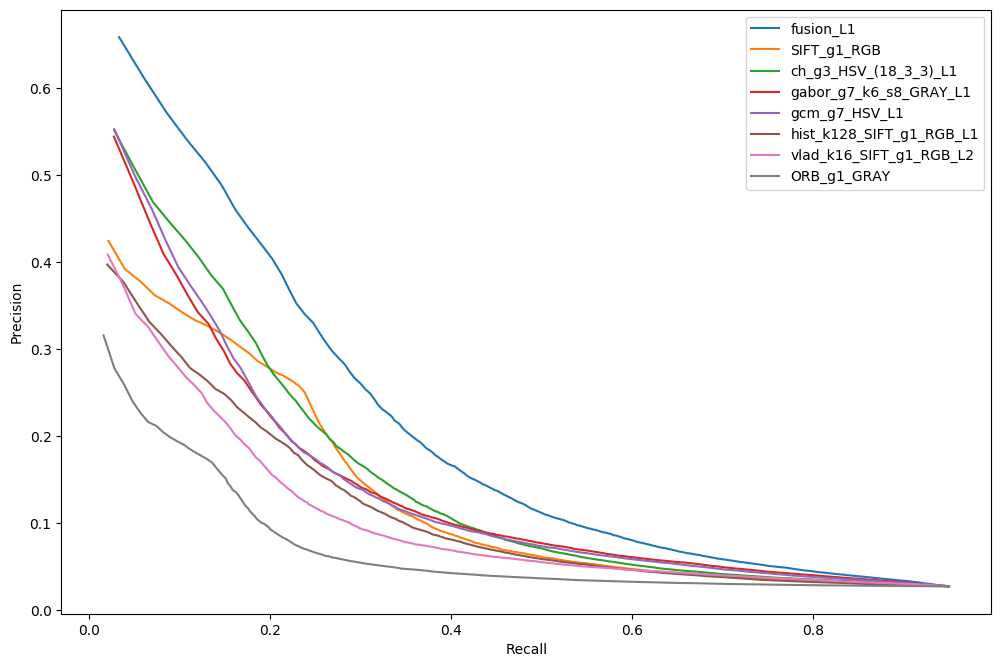

gcm_g7_HSV_L1


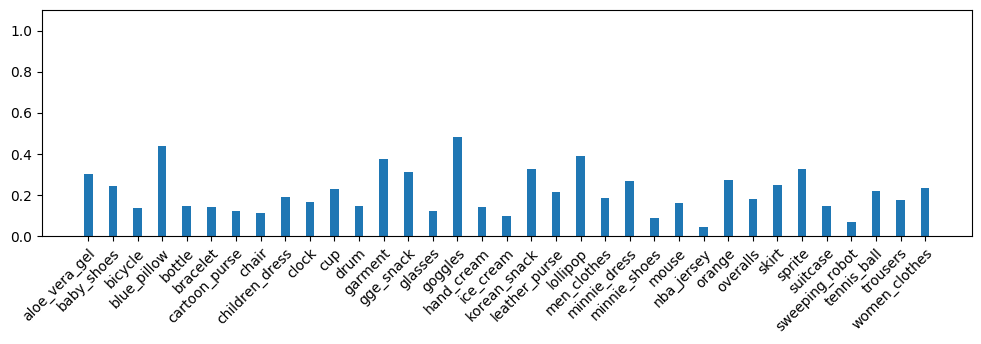

ch_g3_HSV_(18_3_3)_L1


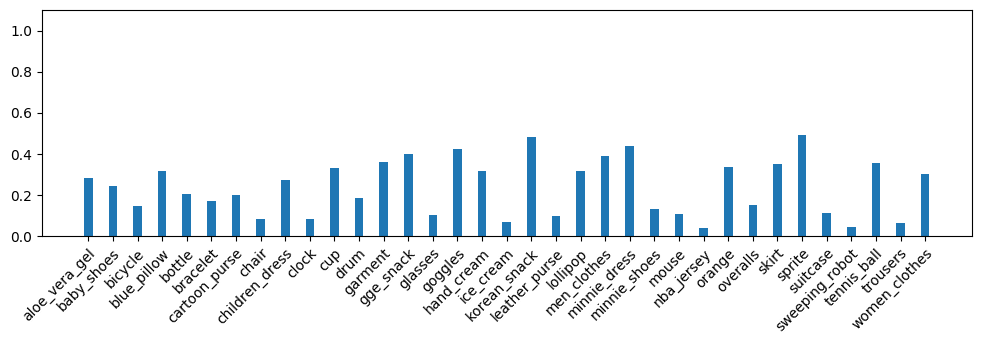

gabor_g7_k6_s8_GRAY_L1


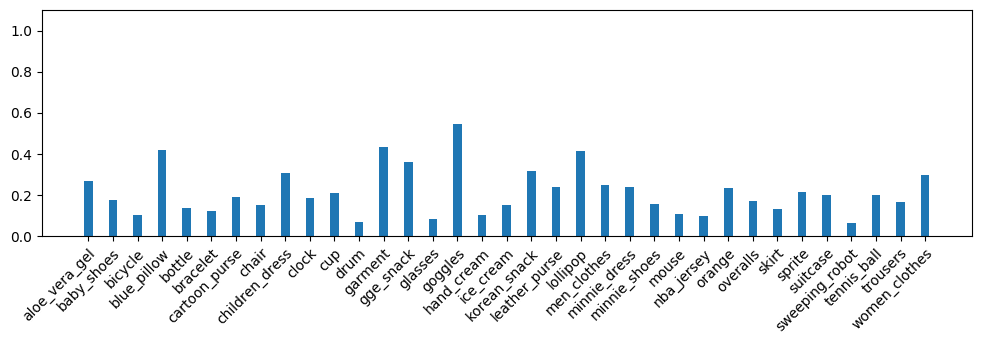

SIFT_g1_RGB


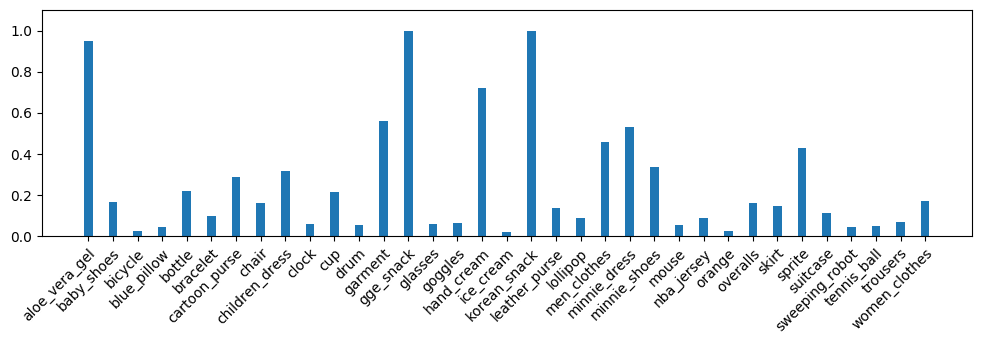

ORB_g1_GRAY


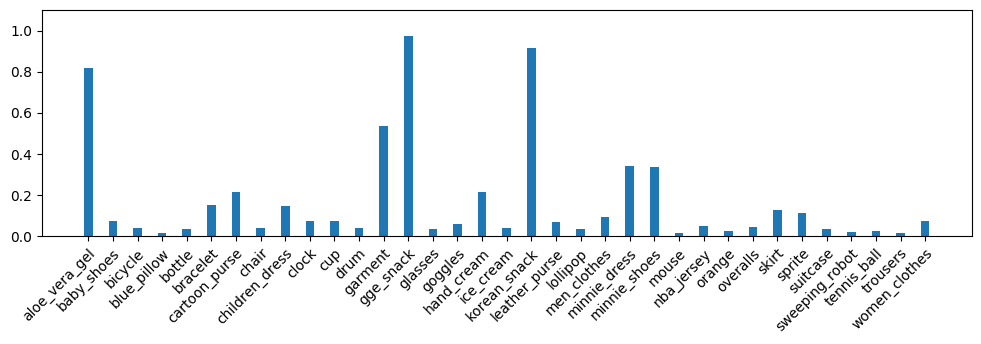

hist_k128_SIFT_g1_RGB_L1


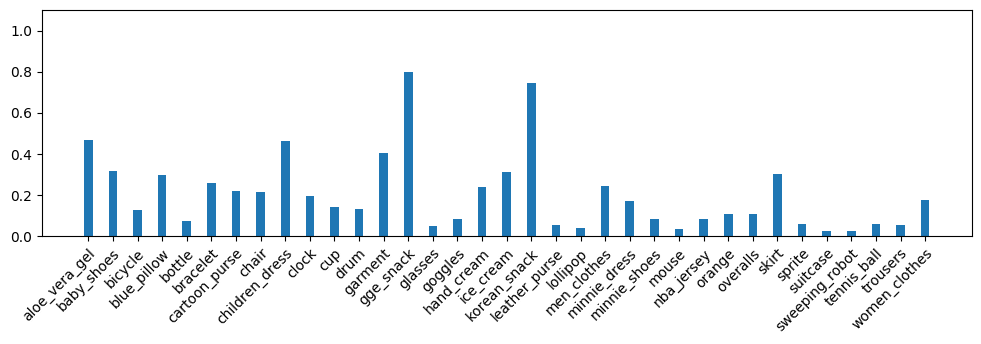

vlad_k16_SIFT_g1_RGB_L2


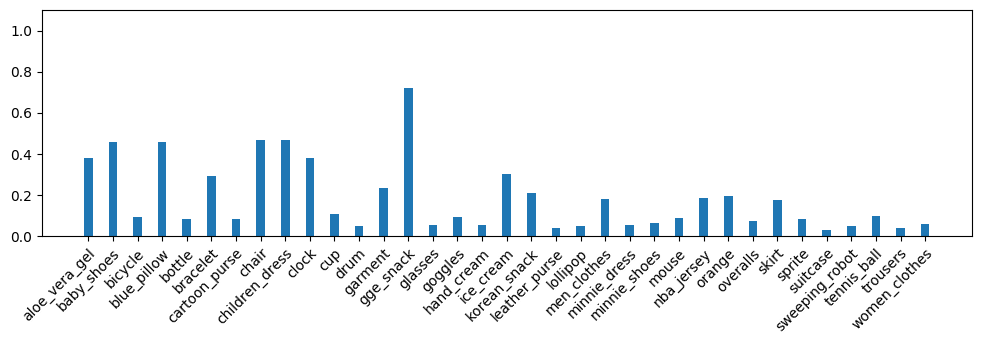

fusion_L1


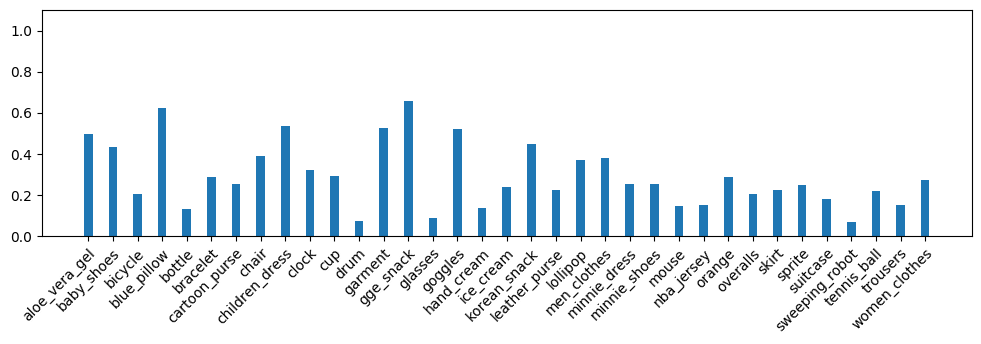

In [17]:
# Comparison between methods with configurations that produce the best results
best_methods = [
    'gcm_g7_HSV_L1', 
    'ch_g3_HSV_(18_3_3)_L1', 
    'gabor_g7_k6_s8_GRAY_L1',
    'SIFT_g1_RGB', 
    'ORB_g1_GRAY',
    'hist_k128_SIFT_g1_RGB_L1',
    'vlad_k16_SIFT_g1_RGB_L2',
    'fusion_L1'
]
best_results = {key: results[key] for key in best_methods}

compareResult(best_results, order='MMAP')

# plot MAP
for key in best_methods:
    print(key)
    # figure size
    org_fz = plt.rcParams['figure.figsize']
    org_dpi = plt.rcParams['figure.dpi']
    plt.rcParams['figure.figsize'] = [12, 3]
    plt.rcParams['figure.dpi'] = 100
    
    fig, ax = plt.subplots()

    ax.bar(np.arange(35), results[key]['MAP'], 0.35)
    ax.set_ylim([0, 1.1])
    ax.set_xticks(np.arange(35))
    ax.set_xticklabels(categories)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()
    
    # reset figure size
    plt.rcParams['figure.figsize'] = org_fz
    plt.rcParams['figure.dpi'] = org_dpi

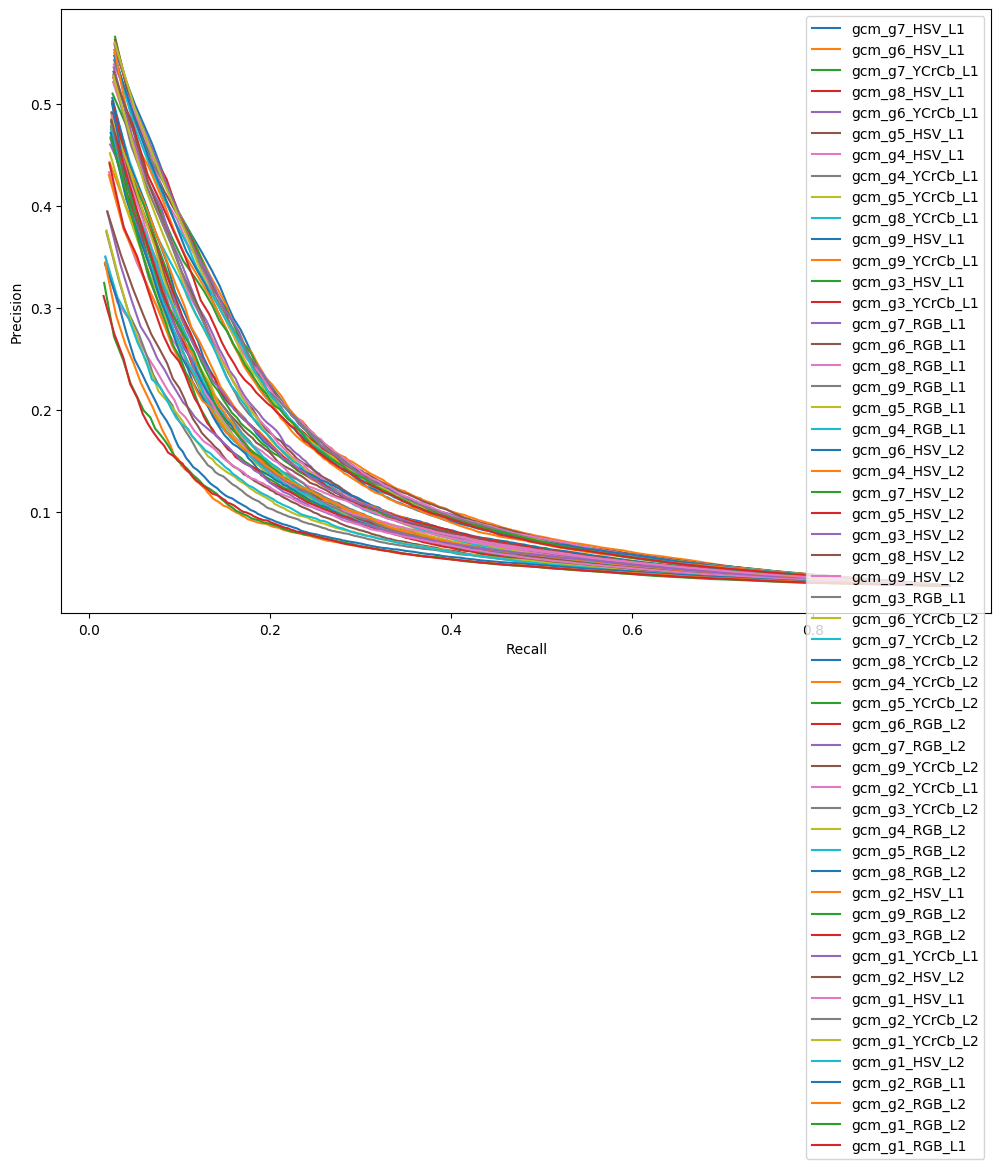

In [18]:
# Comparison -- Grid Color Moments
compareResult(results, order='MMAP', prefix='gcm')

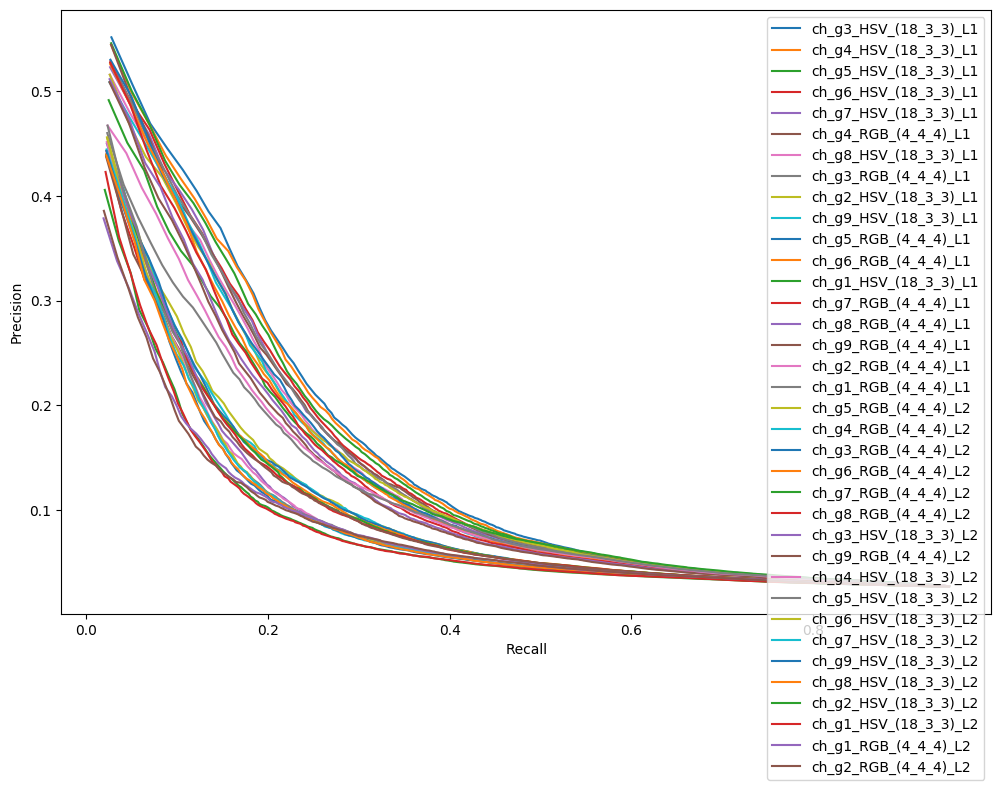

In [19]:
# Comparison -- Color Histogram
compareResult(results, order='MMAP', prefix='ch')

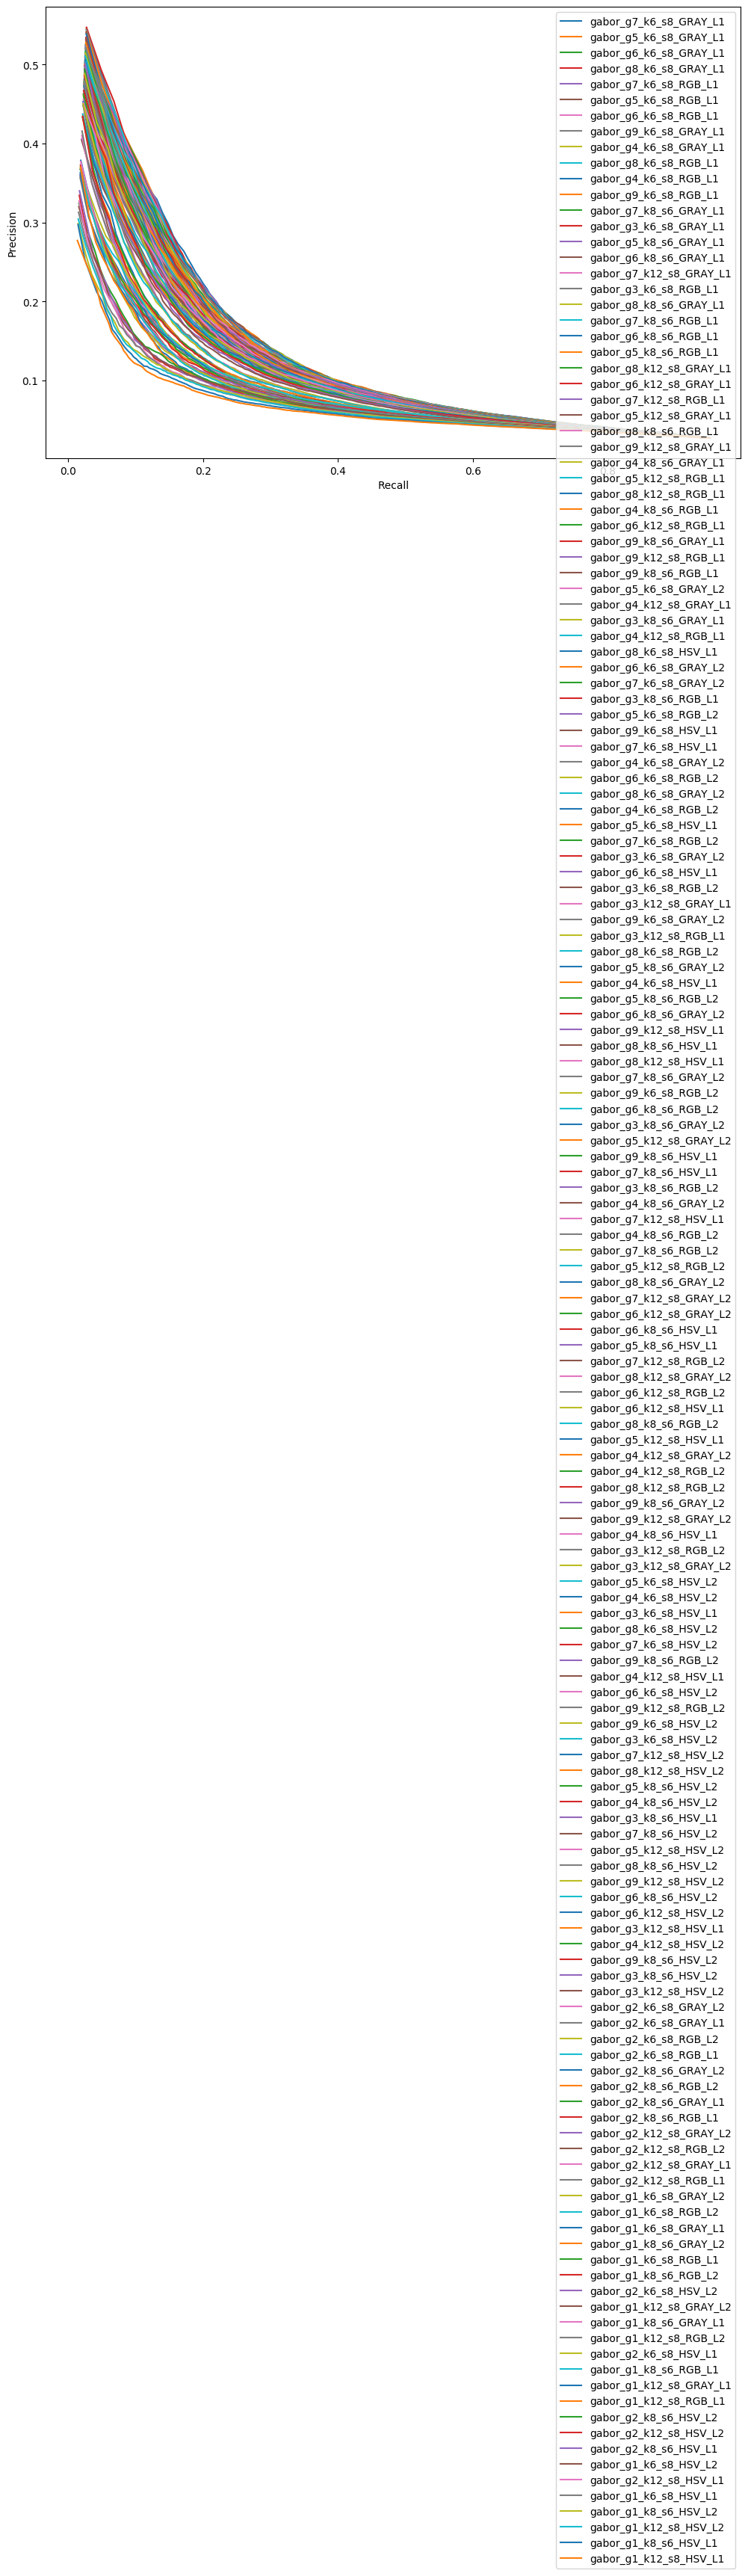

In [20]:
# Comparison -- Gabor Texture
compareResult(results, order='MMAP', prefix='gabor')

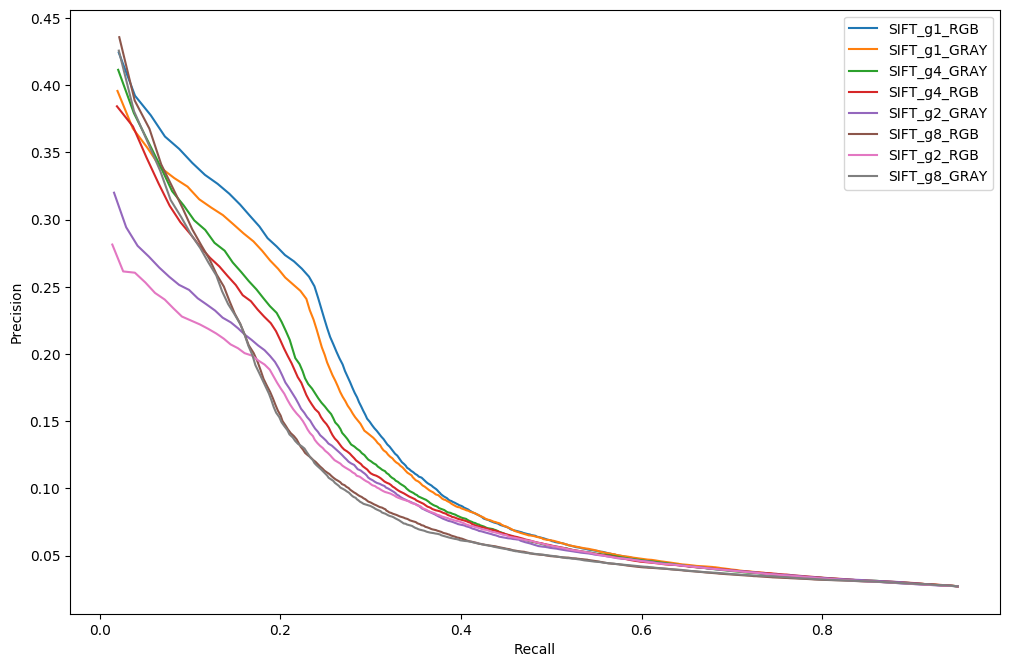

In [21]:
# Comparison -- SIFT
compareResult(results, order='MMAP', prefix='SIFT')

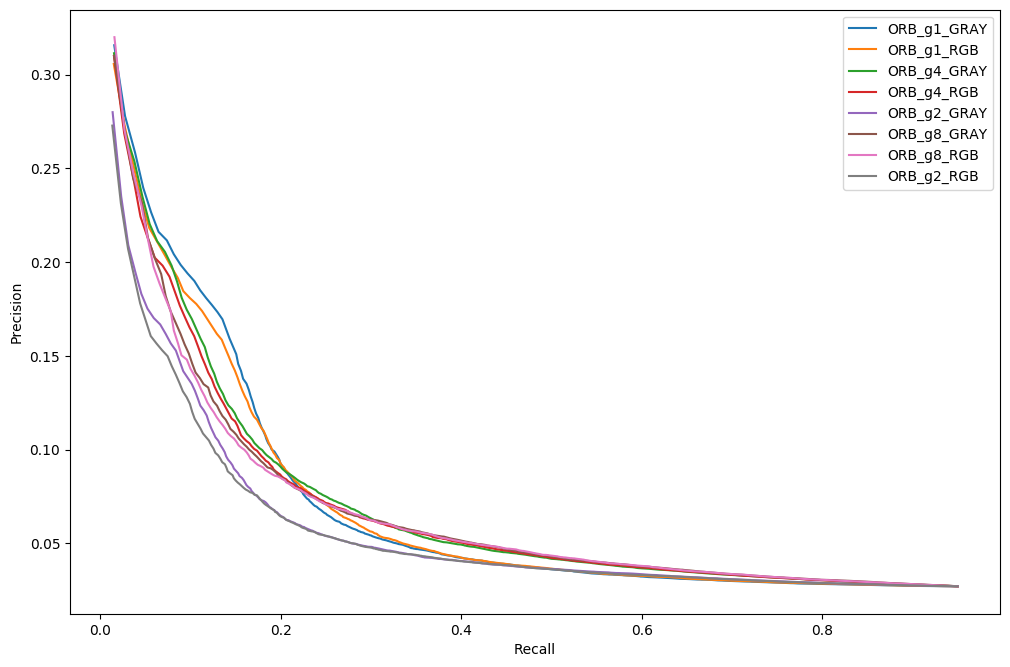

In [22]:
# Comparison -- ORB
compareResult(results, order='MMAP', prefix='ORB')

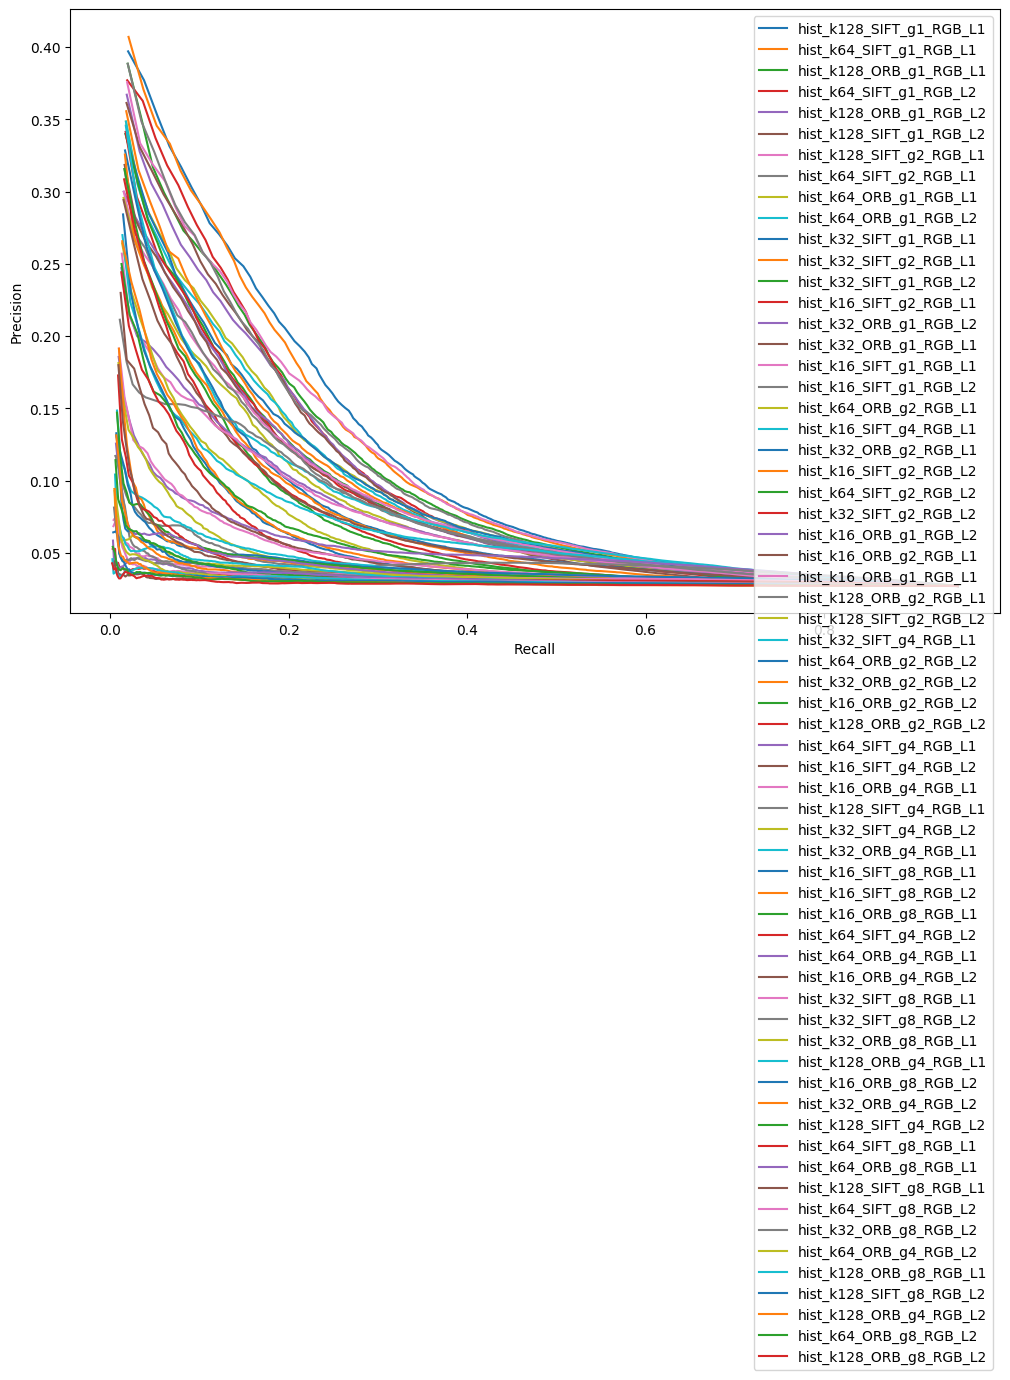

In [23]:
# Comparison -- Histogram of Visual Words
compareResult(results, order='MMAP', prefix='hist')

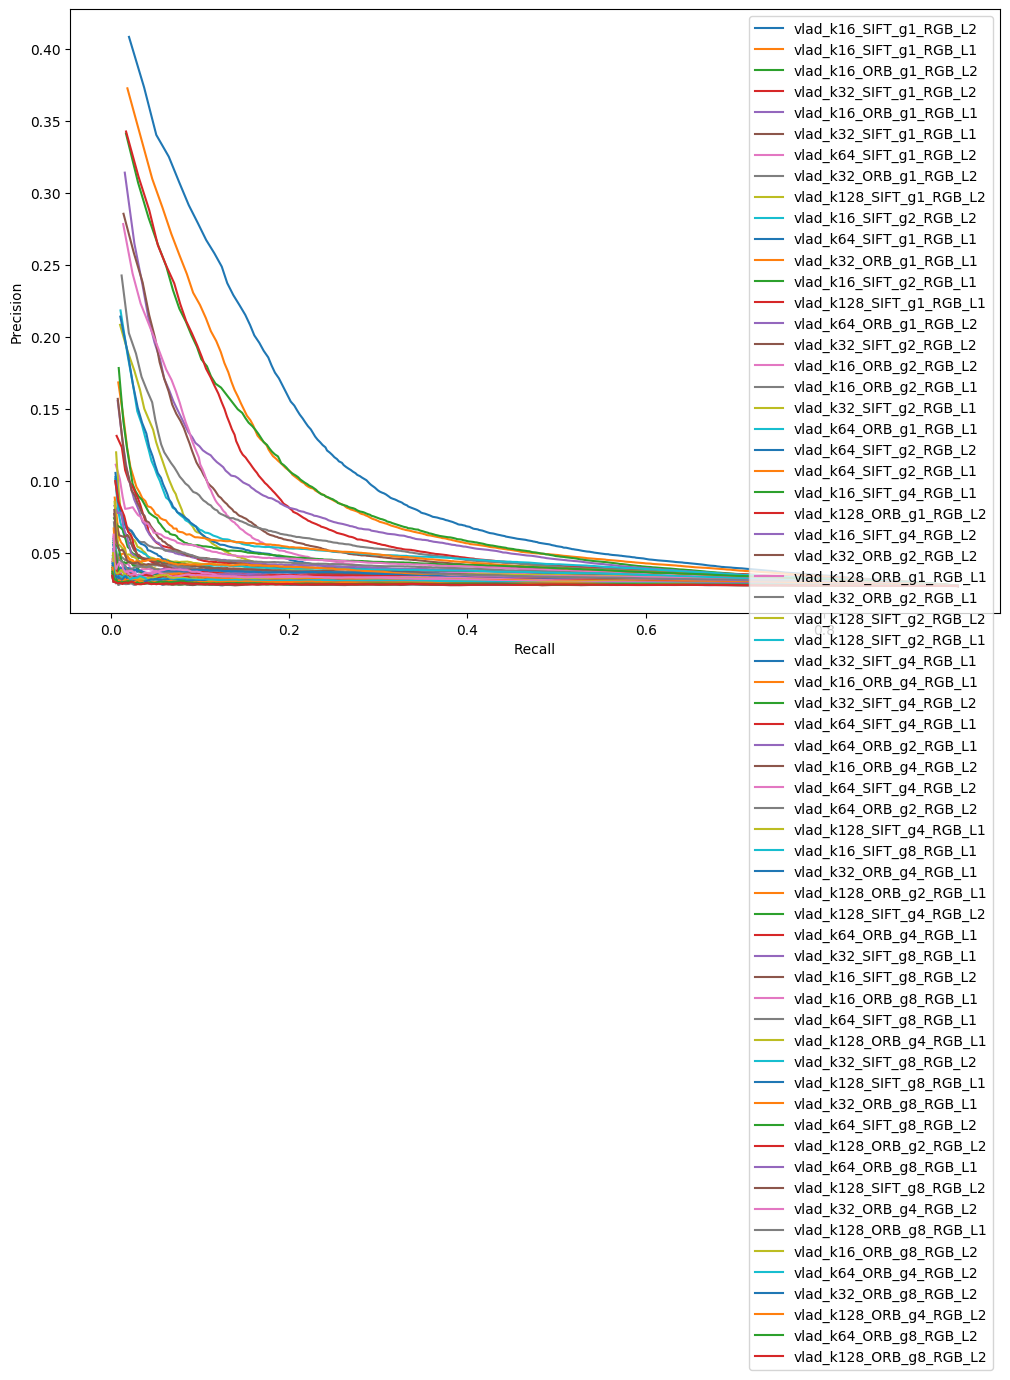

In [24]:
# Comparison -- VLAD
compareResult(results, order='MMAP', prefix='vlad')

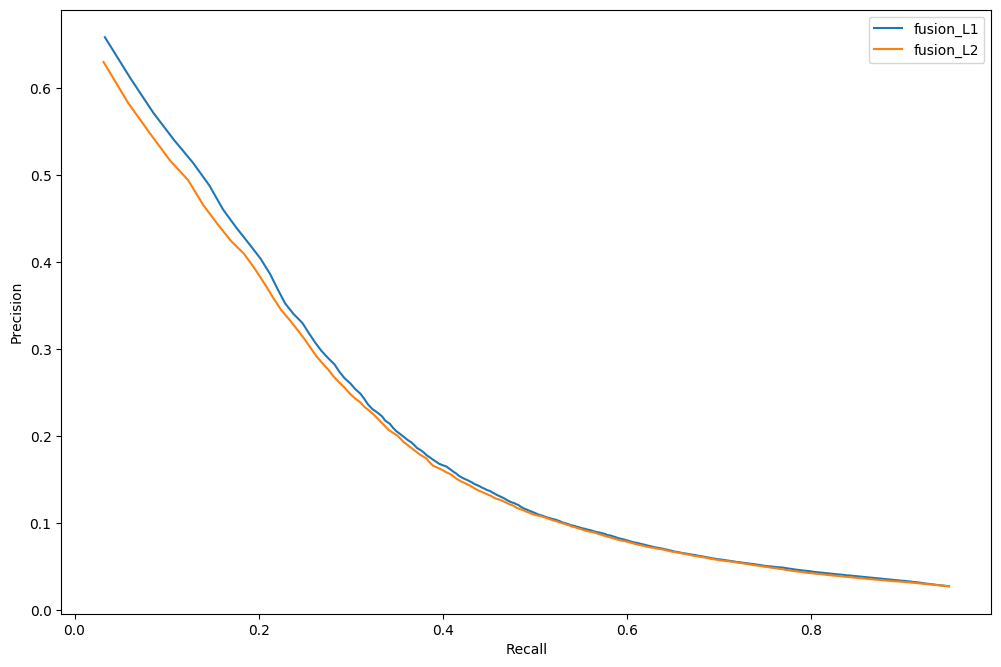

In [25]:
# Comparison -- Fusion
compareResult(results, order='MMAP', prefix='fusion')

# Appendix


In [26]:
for i, cate in enumerate(categories):
    print(i, cate)

0 aloe_vera_gel
1 baby_shoes
2 bicycle
3 blue_pillow
4 bottle
5 bracelet
6 cartoon_purse
7 chair
8 children_dress
9 clock
10 cup
11 drum
12 garment
13 gge_snack
14 glasses
15 goggles
16 hand_cream
17 ice_cream
18 korean_snack
19 leather_purse
20 lollipop
21 men_clothes
22 minnie_dress
23 minnie_shoes
24 mouse
25 nba_jersey
26 orange
27 overalls
28 skirt
29 sprite
30 suitcase
31 sweeping_robot
32 tennis_ball
33 trousers
34 women_clothes


Target Image: data/bicycle/bicycle_1.jpg


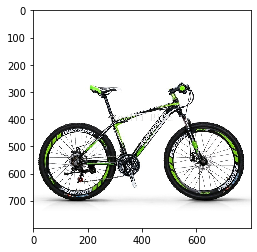

Result Images 0: data/cartoon_purse/cartoon_purse_13.jpg
Result Images 1: data/aloe_vera_gel/aloe_vera_gel_20.jpg
Result Images 2: data/tennis_ball/tennis_ball_12.jpg
Result Images 3: data/bicycle/bicycle_11.jpg
Result Images 4: data/minnie_shoes/minnie_shoes_11.jpg
Result Images 5: data/minnie_shoes/minnie_shoes_2.jpg
Result Images 6: data/aloe_vera_gel/aloe_vera_gel_15.jpg
Result Images 7: data/skirt/skirt_15.jpg
Result Images 8: data/aloe_vera_gel/aloe_vera_gel_3.jpg
Result Images 9: data/aloe_vera_gel/aloe_vera_gel_6.jpg
Result Images 10: data/lollipop/lollipop_15.jpg
Result Images 11: data/bicycle/bicycle_8.jpg
Result Images 12: data/cartoon_purse/cartoon_purse_4.jpg
Result Images 13: data/cartoon_purse/cartoon_purse_11.jpg
Result Images 14: data/minnie_shoes/minnie_shoes_8.jpg
Result Images 15: data/glasses/glasses_3.jpg
Result Images 16: data/skirt/skirt_10.jpg
Result Images 17: data/skirt/skirt_19.jpg
Result Images 18: data/cartoon_purse/cartoon_purse_14.jpg


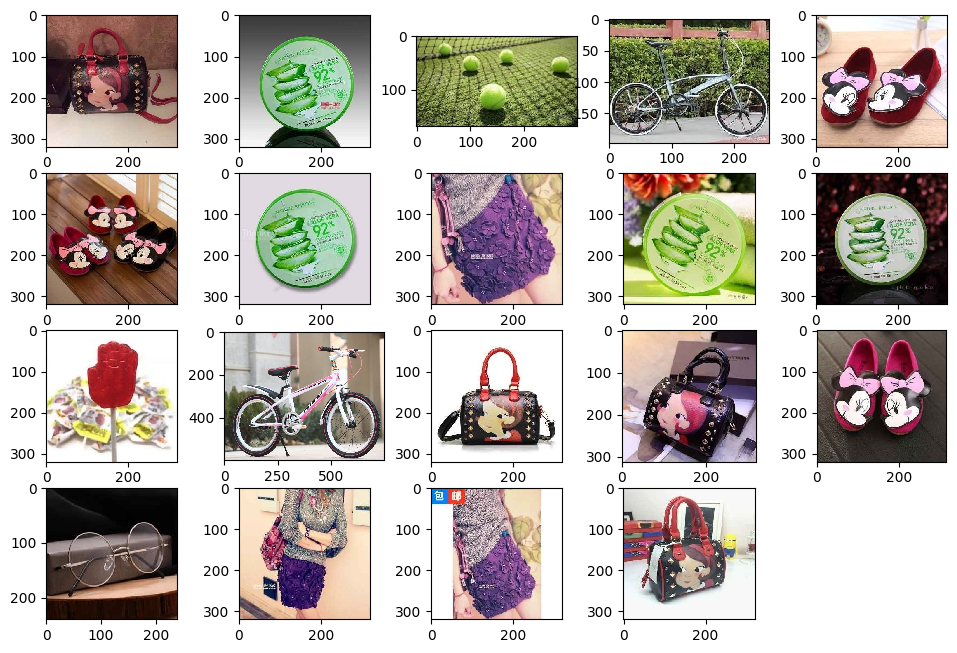

In [27]:
# Visualization
# target image
target_idx = 2*20
cat, filename = getFilename(target_idx)
print('Target Image:', filename)
plt.imshow(Image.open(filename))
plt.show()

# figure size
org_fz = plt.rcParams['figure.figsize']
org_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# queried images
for i in range(19):
    result_idx = ranked[target_idx, i]
    cat, filename = getFilename(result_idx)
    print('Result Images {}: {}'.format(i, filename))
    plt.subplot(4, 5, i+1)
    plt.imshow(Image.open(filename))
plt.show()

# reset figure size
plt.rcParams['figure.figsize'] = org_fz
plt.rcParams['figure.dpi'] = org_dpi

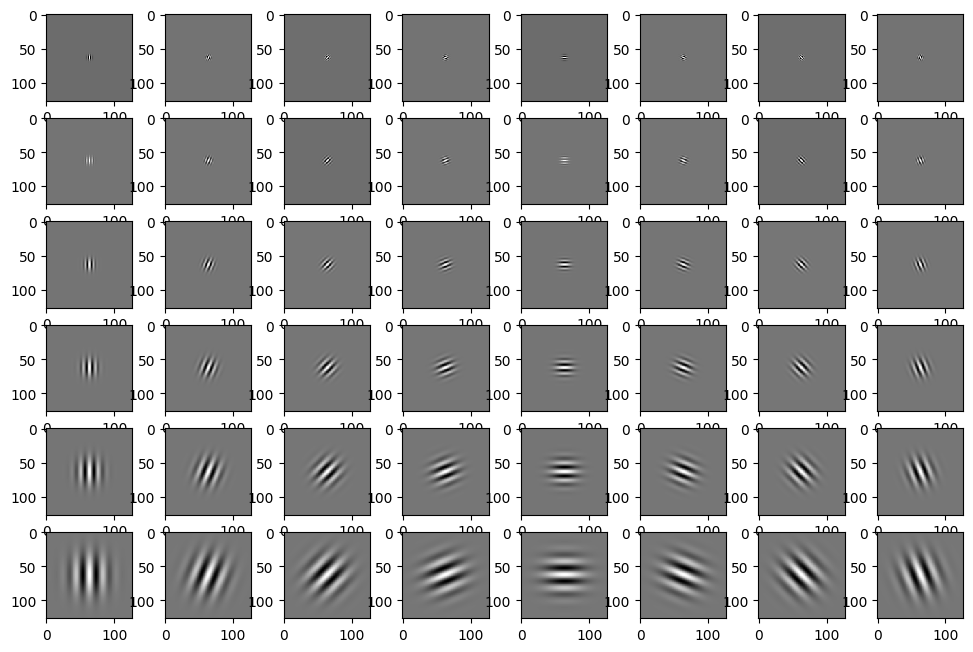

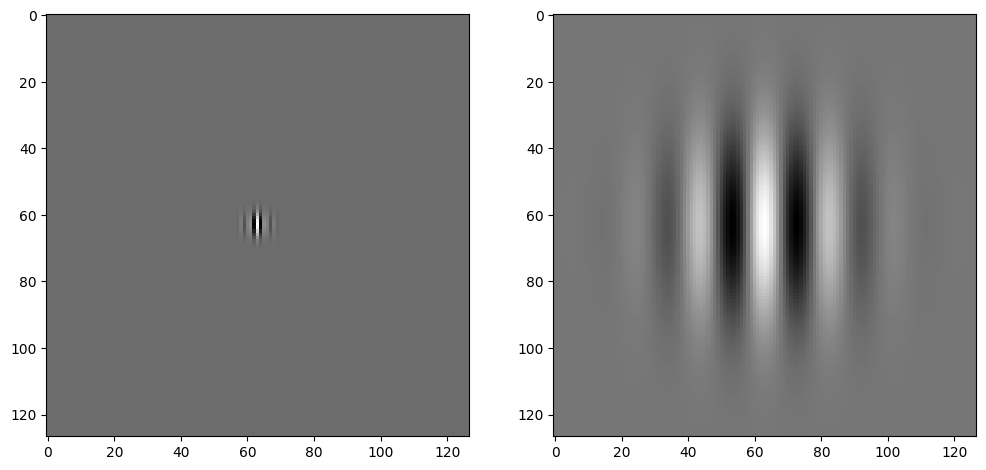

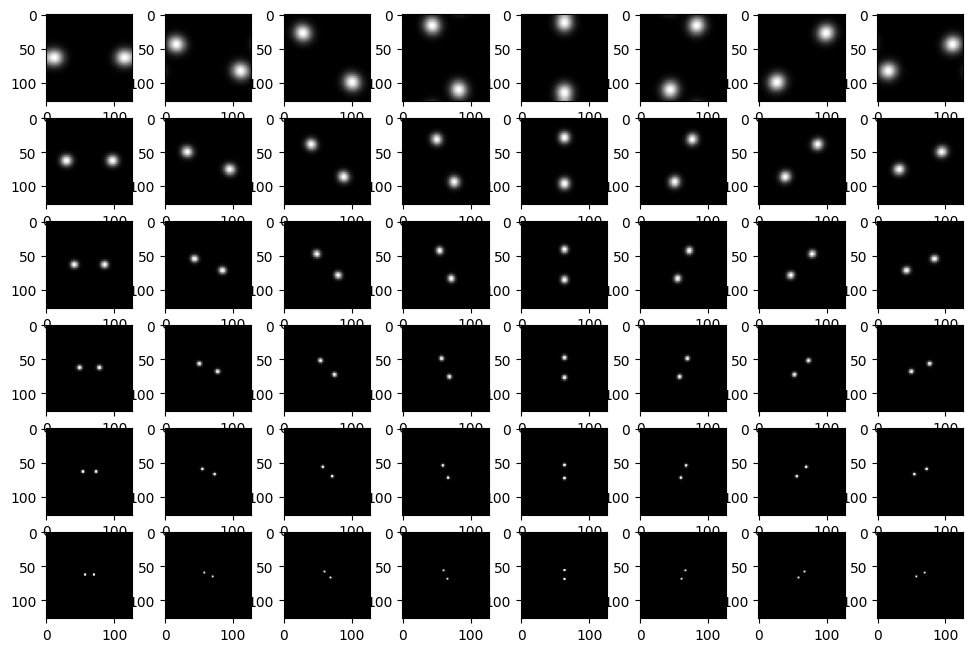

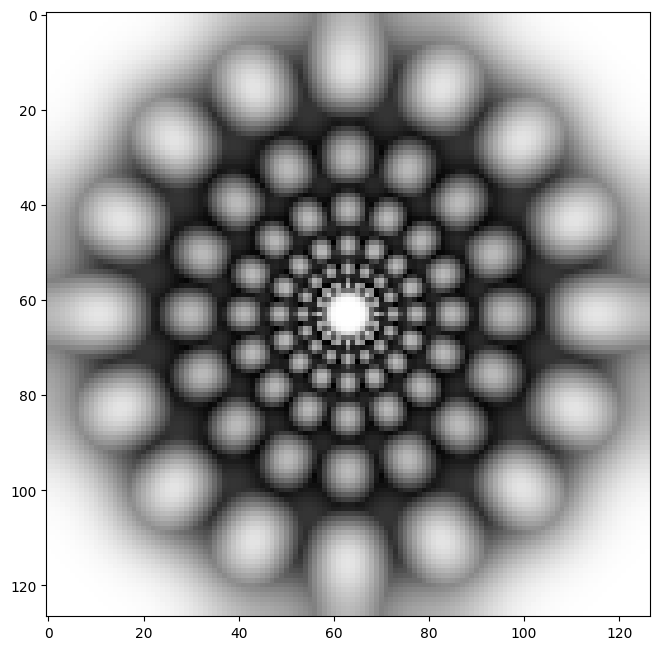

In [28]:
# Visualization Gabor filter
# figure size
org_fz = plt.rcParams['figure.figsize']
org_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# generate filters
K = 8
S = 6
filters = genGaborFilters(K=K, S=S)

# display filters
for i in range(S*K):
    plt.subplot(S, K, i+1)
    plt.imshow(filters[i], 'gray')
plt.show()

# display filters with certain orientation
orientation = 0
plt.subplot(1, 2, 1)
plt.imshow(filters[orientation], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(filters[K*(S-1)+orientation], 'gray')
plt.show()

# display Fourior transform of Gabor filter
half_peaks = None
for i in range(S*K):
    f = np.fft.fft2(filters[i])
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    half_peak = np.abs(mag - np.max(mag)/2)
    if half_peaks is None:
        half_peaks = half_peak/np.max(mag)
    else:
        half_peaks += half_peak/np.max(mag)
    plt.subplot(S, K, i+1)
    plt.imshow(mag, 'gray')
plt.show()

# display half peak
plt.imshow(half_peaks, 'gray')
plt.show()

# reset figure size
plt.rcParams['figure.figsize'] = org_fz
plt.rcParams['figure.dpi'] = org_dpi